## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

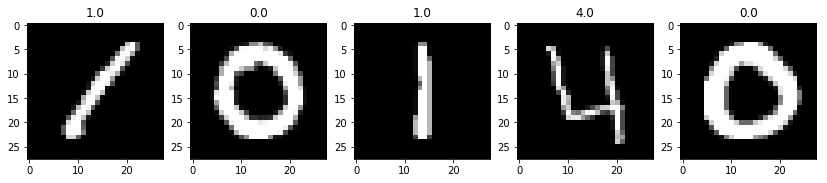

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [6]:
# Метод главных компонент

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [7]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [9]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

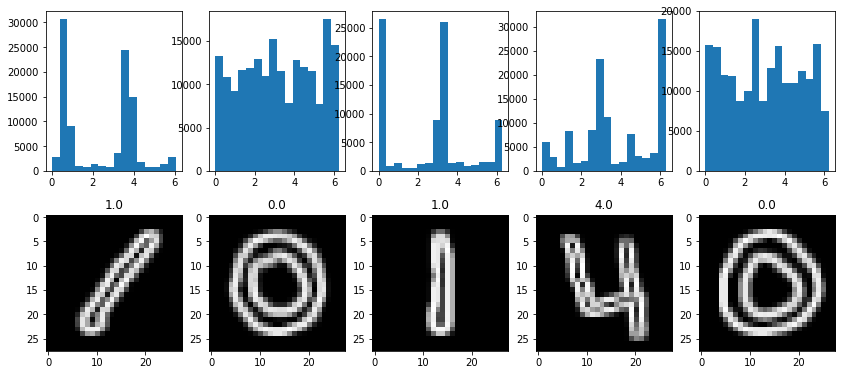

In [11]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [12]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [13]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [14]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [15]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [16]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [17]:
# Попробуем 3 разных модели

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [19]:
# Метод случайных соседей

In [20]:
knn = KNeighborsClassifier(algorithm='kd_tree', leaf_size=20)
knn.fit(x_train, y_train)
pred_val = knn.predict(x_train)
acc_knn = accuracy_score(y_val, pred_val)
           
print('Accuracy: %s' % acc_knn)

ValueError: Found input variables with inconsistent numbers of samples: [8400, 33600]

In [21]:
print(classification_report(y_val, pred_val))

ValueError: Found input variables with inconsistent numbers of samples: [8400, 33600]

In [22]:
print(confusion_matrix(y_val, pred_val))

ValueError: Found input variables with inconsistent numbers of samples: [8400, 33600]

In [23]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

NameError: name 'centroids' is not defined

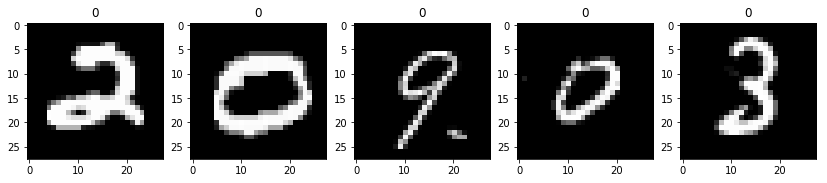

In [24]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [25]:
# Логистическая регрессия

In [26]:
logReg = LogisticRegression()
logReg.fit(x_train, y_train)
pred_val = logReg.predict(x_train)
acc_log = accuracy_score(y_val, pred_val)
           
print('Accuracy: %s' % acc_log)

D:\l\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\l\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


ValueError: Found input variables with inconsistent numbers of samples: [8400, 33600]

In [27]:
print(classification_report(y_val, pred_val))

ValueError: Found input variables with inconsistent numbers of samples: [8400, 33600]

In [28]:
print(confusion_matrix(y_val, pred_val))

ValueError: Found input variables with inconsistent numbers of samples: [8400, 33600]

In [29]:
pred_test = logReg.predict(test)

ValueError: X has 784 features per sample; expecting 16

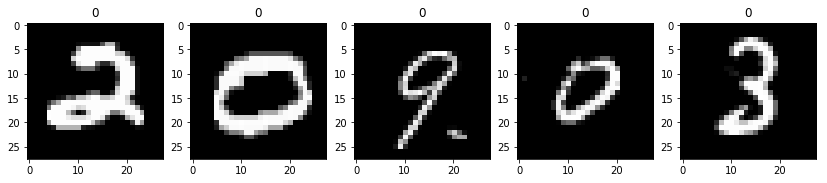

In [30]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

In [31]:
# Случайный лес

In [32]:
randomForest = RandomForestClassifier()
randomForest.fit(x_train, y_train)
y_pred_rf = randomForest.predict(x_train)
acc_rf = accuracy_score(y_pred_rf, y_train)

print('Accuracy: %s' % acc_rf)

D:\l\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.9911904761904762


## Предсказания на тестовыйх данных

In [ ]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

In [ ]:
!head submit.txt

In [ ]:
# Your submission scored 0.41700